In [431]:
# imports
import requests
import io
import re
import math
from time import sleep

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import geopandas as gpd
import folium
import branca.colormap as cm

In [33]:
min_year = 1980

# 1) Data Processing

### 1.1) Demographic Data

##### 1.1.1) ACS 1-year estimates

In [2]:
### Store relevant group codes in "variables", group metadata in "variables_df"
variables_df = pd.read_json('data/demographic/variables.json',orient='index')

variables = [
    # race
    'B02001_007E',
    'B02001_002E',
    'B02001_001E',
    'B02001_006E',
    'B02001_005E',
    'B02001_004E',
    'B02001_003E',
    # total population
    'B01003_001E',
]

# sex and age
variables.extend(['B01001_00' + str(x) + 'E' for x in range(2,10)])
variables.extend(['B01001_0' + str(x) + 'E' for x in range(10,50)])

# >= 18 yrs by educational attainment
edu_df = variables_df[(variables_df['concept'] == 
                       'SEX BY AGE BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 18 YEARS AND OVER')]
desc_sep = [x.split("!!") for x in edu_df['label'].tolist()]
idx = [i for i in range(len(desc_sep)) if len(desc_sep[i]) == 5]
edu_codes = edu_df.iloc[idx,:].index.tolist()
idx_B = [i for i,x in enumerate(edu_codes) if x[0]=="B"]

variables.extend([edu_codes[i] for i in idx_B])

# map group codes to general groups
variables_df = variables_df.loc[variables,:]
var_map = {}
for i in range(len(variables_df)):
    var_map[variables_df.index[i]] = variables_df.iloc[i,0].split("!!")[-1]

In [3]:
### Get demographic estimtates from ACS 1-yr estimates using census API
def get_demographic(year):
    # scrape survey data for selected year and features ("groups")
    raw_dict = {}
    i=0
    while i < len(variables):
        # subset groups (API can only handle 50 at a time)
        i = min(i+49, len(variables))
        groups = ','.join(variables[i-49:i])
        # get page
        base_url = 'https://api.census.gov/data/' + str(year) + '/acs/acs1?get=NAME,' + groups + '&for=state:*'
        home_page = requests.get(base_url)
        if home_page.status_code != 200:
            print('ERROR: Status code: ', home_page.status_code)
        sleep(1)

        # convert text -> csv -> data frame -> dictionary
        text = io.StringIO(home_page.text.replace('[', '').replace(']', ''))
        df = pd.read_csv(text, sep=",")
        raw_dict.update(df.to_dict())
    del raw_dict['Unnamed: 51']
    df_all = pd.DataFrame.from_dict(raw_dict)

    # aggregate data into general groups
    data_dict = {}
    for c in var_map.values():
        data_dict[c] = [0]*len(df_all)
    data_dict['STATE'] = df_all['NAME'].tolist()
    df_all = df_all.drop(columns=['NAME','state'])
    for code in df_all.columns:
        data_dict[var_map[code]] = [x + y for x, y in zip(data_dict[var_map[code]], df_all[code].to_list())]
    
    # aggregate some data into new groups to match other demographic data, remove unnecessary columns
    df = pd.DataFrame.from_dict(data_dict)
    df['35 to 44 years'] = df['35 to 39 years'] + df['40 to 44 years']
    df['45 to 54 years'] = df['45 to 49 years'] + df['50 to 54 years']
    df['65 to 74 years'] = df['65 and 66 years'] + df['67 to 69 years'] + df['70 to 74 years']
    df['75 to 84 years'] = df['75 to 79 years'] + df['80 to 84 years']
    df["Less than Bachelor's degree"] = df['Less than 9th grade'] + df["9th to 12th grade, no diploma"] + df["High school graduate (includes equivalency)"] + df["Some college, no degree"] + df["Associate's degree"]
    df["Asian and Pacific Islander and Other"] = df["Asian alone"] + df["Native Hawaiian and Other Pacific Islander alone"]
    df = df.drop(columns=[
        '35 to 39 years','40 to 44 years',
        '45 to 49 years','50 to 54 years',
        '65 and 66 years','67 to 69 years','70 to 74 years',
        '75 to 79 years','80 to 84 years',
        'High school graduate (includes equivalency)',
        'Some college, no degree',
        "Associate's degree",
        "Less than 9th grade",
        "9th to 12th grade, no diploma",
        "Some other race alone",
        "Native Hawaiian and Other Pacific Islander alone",
        "Asian alone"
    ])
    df = df.rename(columns={
        'White alone': 'White', 
        'American Indian and Alaska Native alone': 'American Indian and Alaska Native',
        'Black or African American alone': 'Black or African American',
        'Total': 'Population'
    })
    df['YEAR'] = [year]*len(df)
    # save as csv
    df.to_csv('data/demographic/demographic_'+str(year)+'.csv', index=False)

In [4]:
years = [2005,2007,2009,2011,2013,2015,2017,2019]
for year in years:
    get_demographic(year)

##### 1.1.2) Combine ACS and Census Data

In [6]:
# combine all demographic data
cols = {
    'AV0AA': 'Population',

    'AV1AA': 'Male',
    'AV1AB': 'Female',

    'B57AA': 'Under 5 years',
    'B57AB': '5 to 9 years',
    'B57AC': '10 to 14 years',
    'B57AD': '15 to 17 years',
    'B57AE': '18 and 19 years',
    'B57AF': '20 years',
    'B57AG': '21 years',
    'B57AH': '22 to 24 years',
    'B57AI': '25 to 29 years',
    'B57AJ': '30 to 34 years',
    'B57AK': '35 to 44 years',
    'B57AL': '45 to 54 years',
    'B57AM': '55 to 59 years',
    'B57AN': '60 and 61 years',
    'B57AO': '62 to 64 years',
    'B57AP': '65 to 74 years',
    'B57AQ': '75 to 84 years',
    'B57AR': '85 years and over',

    'B18AA': 'White',
    'B18AB': 'Black or African American',
    'B18AC': 'American Indian and Alaska Native',
    'B18AD': 'Asian and Pacific Islander and Other',
    
    'B86AA': "Less than Bachelor's degree",
    'B86AB': "Bachelor's degree",
    'B86AC': "Graduate or professional degree"
}

dem = pd.read_csv('data/demographic/demographic_1980-2010.csv')
dem = dem.drop(columns=['GISJOIN','NAME','STATEFP','STATENH'])
dem = dem.rename(columns=cols)
for year in years:
    dem_new = pd.read_csv('data/demographic/demographic_'+str(year)+'.csv')
    dem = pd.concat([dem, dem_new])
dem = dem[(dem['STATE'] != 'Puerto Rico')]
dem.to_csv('data/demographic/demographic_raw.csv',index=False)

##### 1.1.3) Transform raw population counts to fractions of total population

In [21]:
dem_full = pd.read_csv('data/demographic/demographic_raw.csv')
dem = dem_full[[
    'YEAR','STATE','Population','Male','Female',
    'White', 'Black or African American', 'American Indian and Alaska Native','Asian and Pacific Islander and Other',
    "Less than Bachelor's degree", "Bachelor's degree","Graduate or professional degree"]].copy()
dem.loc[(dem['STATE'] == 'District Of Columbia'),['STATE']] = 'District of Columbia'

# adjust age categories
dem["Under 18 years"] = dem_full['Under 5 years'] + dem_full['5 to 9 years'] + dem_full['10 to 14 years'] + dem_full['15 to 17 years']
dem["18 to 29 years"] = dem_full['18 and 19 years'] + dem_full['20 years'] + dem_full['21 years'] + dem_full['22 to 24 years'] + dem_full['25 to 29 years']
dem["30 to 44 years"] = dem_full['30 to 34 years'] + dem_full['35 to 44 years']
dem["45 to 64 years"] = dem_full['45 to 54 years'] + dem_full['55 to 59 years'] + dem_full['60 and 61 years'] + dem_full['62 to 64 years']
dem["65 years and over"] = dem_full['65 to 74 years'] + dem_full['75 to 84 years'] + dem_full['85 years and over']

for c in dem.columns:
    if c not in ['YEAR','STATE','Population']:
        dem[c] = dem[[c]].apply(lambda x: x/dem['Population'])
dem.head()

,YEAR,STATE,Population,Male,Female,White,Black or African American,American Indian and Alaska Native,Asian and Pacific Islander and Other,Less than Bachelor's degree,Bachelor's degree,Graduate or professional degree,Under 18 years,18 to 29 years,30 to 44 years,45 to 64 years,65 years and over
0,1980,Alabama,3893888,0.480634,0.519366,0.737897,0.255858,0.002389,0.002738,0.625016,0.044568,0.031708,0.298480,0.213273,0.183109,0.192136,0.113001
1,1980,Alaska,401851,0.530149,0.469851,0.776328,0.034212,0.160151,0.020689,0.558423,0.060739,0.055344,0.325357,0.269797,0.239355,0.136757,0.028735
2,1980,Arizona,2718215,0.492213,0.507787,0.831534,0.027282,0.056798,0.009036,0.601747,0.056344,0.050722,0.291179,0.222531,0.186060,0.187155,0.113075
3,1980,Arkansas,2286435,0.483149,0.516851,0.826586,0.163147,0.005579,0.003163,0.637450,0.041077,0.027915,0.293634,0.197897,0.178636,0.193168,0.136666
4,1980,California,23667902,0.492924,0.507076,0.769876,0.076841,0.009790,0.055475,0.606014,0.061672,0.062599,0.269942,0.231757,0.203862,0.192434,0.102005


##### 1.1.4) Impute missing demographic data (linear regression)

In [22]:
cols = [c for c in dem.columns if c not in ['YEAR','STATE']]
yrs = [1980,1990,2000,2005]
states = dem['STATE'].unique()
for y in range(len(yrs)-1):
    min_yr = yrs[y]
    max_yr = yrs[y+1]
    for state in states:
        y1 = dem[((dem['YEAR'] == min_yr) & (dem['STATE'] == state))]
        y2 = dem[((dem['YEAR'] == max_yr) & (dem['STATE'] == state))]
        X = np.array([min_yr,max_yr]).reshape(-1,1)
        if min_yr == 1980:
            yr_range = np.arange(min_yr-1,max_yr,2)
        else:
            yr_range = np.arange(min_yr+1,max_yr,2)
        y_pred = []
        for c in cols:
            y = np.array([y1[c].values[0],y2[c].values[0]])
            linreg = LinearRegression().fit(X,y)
            y_pred.append(linreg.predict(yr_range.reshape(-1,1)))
        for i in range(len(yr_range)):
            new_row = {'YEAR':yr_range[i],'STATE':state}
            for j in range(len(cols)):
                new_row.update({cols[j]:y_pred[j][i]})
            dem = dem.append(new_row, ignore_index=True)
dem['YEAR'] = dem['YEAR'] + 1
dem.to_csv('data/demographic/demographic_all.csv',index=False)

### 1.2) Economic Data

In [144]:
# reformat unemployment data
unemp = pd.read_csv('data/economic/unemployment_1976-2020.csv')
ue_dict = {
    'STATE': [], 
    'YEAR': [], 
    'Unemployment_4': [],
    'Unemployment_5': [],
    'Unemployment_6': [],
    'Unemployment_7': [],
    'Unemployment_8': [],
    'Unemployment_9': []
}
for state in unemp['STATE'].unique():
    state_ue = unemp[(unemp['STATE'] == state)]
    for year in state_ue['Year'].unique():
        ue_dict['STATE'].append(state)
        ue_dict['YEAR'].append(year)
        for i in range(4,10):
            period = 'M0' + str(i)
            sub_df = state_ue[((state_ue['Year'] == year) & (state_ue['Period'] == period))]['Value']
            ue_dict['Unemployment_'+str(i)].append(float(sub_df.values))
unemp_final = pd.DataFrame.from_dict(ue_dict)
unemp_final = unemp_final[(unemp_final['YEAR']>=min_year)]
unemp_final.to_csv("data/economic/unemployment.csv",index=False)

In [145]:
# reformat disposable income data (use previous year data)
dpi = pd.read_csv('data/economic/disposable_income_1979-2019.csv')
dpi = dpi[(dpi['LineCode'] == 53)] # per capita disposable income
dpi = dpi.drop(columns=['GeoFips','LineCode','Description'])
dpi = dpi.rename(columns={'GeoName':'STATE'})
dpi_dict = {'STATE': [], 'YEAR': [], 'Disposable Income Per Capita': []}
for state in dpi['STATE']:
    for year in dpi.columns:
        if year != 'STATE':
            dpi_dict['STATE'].append(state)
            dpi_dict['YEAR'].append(int(year)+1)
            dpi_dict['Disposable Income Per Capita'].append(float(dpi[(dpi['STATE'] == state)][year]))
dpi_final = pd.DataFrame.from_dict(dpi_dict)
dpi_final = dpi_final[(dpi_final['YEAR']>=min_year)]
dpi_final.to_csv("data/economic/disposable_income.csv",index=False)

In [146]:
# reformat GDP data
gdp = pd.read_csv('data/economic/gdp_growth_1977-2020.csv')
gdp = gdp.drop(columns=['GeoFips'])
gdp = gdp.rename(columns={'GeoName':'STATE'})
gdp_dict = {'STATE': [], 'YEAR': [], 'GDP Growth': []}
for state in gdp['STATE']:
    for yr_range in gdp.columns:
        if yr_range != 'STATE':
            year = yr_range.split('-')[1]
            gdp_dict['STATE'].append(state)
            gdp_dict['YEAR'].append(int(year))
            gdp_dict['GDP Growth'].append(float(gdp[(gdp['STATE']==state)][yr_range]))
gdp_final = pd.DataFrame.from_dict(gdp_dict)
gdp_final = gdp_final[(gdp_final['YEAR']>=min_year)]
gdp_final.to_csv('data/economic/gdp_growth.csv',index=False)

In [147]:
econ_df = unemp_final.merge(dpi_final,how='outer')
econ_df = econ_df.merge(gdp_final,how='outer')
econ_df['Avg Unemployment'] = econ_df[['Unemployment_4','Unemployment_5','Unemployment_6','Unemployment_7',
                                       'Unemployment_8','Unemployment_9']].mean(axis=1)
econ_df = econ_df.drop(columns=['Unemployment_4','Unemployment_5','Unemployment_6','Unemployment_7','Unemployment_8','Unemployment_9'])
econ_df.to_csv('data/economic/economic_full.csv',index=False)

### 1.3) Incumbency Data

In [122]:
# former senators
url_former = 'https://en.wikipedia.org/wiki/List_of_former_United_States_senators'
page_former = requests.get(url_former)
data_all_former = re.findall("\n<td><a href=\"/wiki/.*title=.*\">(.*)</a></td>\n<td>(.*)</td>\n<td>.*</td>\n<td>(.*)</td>\n<td>(.*)</td>", page_former.text)
data = [d for d in data_all_former if int(d[1][-4:]) >= min_year]

In [123]:
# current senators
url_current = 'https://en.wikipedia.org/wiki/List_of_current_United_States_senators'
page_current = requests.get(url_current)
data_all_current = re.findall("\n<tr>\n<td rowspan=\"2\"><a.*>(.*)</a>.*\n.*\n.*\n.*\n.*<a.*>(.*)</a>.*\n.*\n.*\n.*\n.*<a.*>(.*)</a>.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*<td.*>.*, (.*)\n</td>.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*<a.*>(.*)</a>.*\n.*\n.*\n.*\n.*<a.*>(.*)</a>.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*<td.*>.*, (\d+).*\n</td>", page_current.text)
for d in data_all_current:
    data.append((d[1],d[3]+'-2020',d[0],d[2]))
    data.append((d[4],d[6]+'-2020',d[0],d[5]))

In [124]:
incumbent = {'NAME': [], 'START':[], 'END': [], 'STATE': [], 'PARTY': [], 'TERMS': []}
for d in data:
    start = int(d[1][0:4])
    end = int(d[1][-4:])
    term = end - start
    span = d[1].split("<br />")
    if len(span) != 1:
        # non-continuous terms
        party = d[3].split("<br />")
        for i,yr in enumerate(span):
            if int(yr[-4:]) >= min_year:
                incumbent['NAME'].append(d[0])
                incumbent['STATE'].append(d[2])
                incumbent['START'].append(int(yr[0:4]))
                incumbent['END'].append(int(yr[-4:]))
                incumbent['TERMS'].append(max((int(yr[-4:]) - int(yr[0:4]))//6,1))
                if len(party) == 1:
                    incumbent['PARTY'].append(d[3])
                elif party[i] == '""':
                    incumbent['PARTY'].append(party[i-1])
                else:
                    incumbent['PARTY'].append(party[i])
    else:
        incumbent['END'].append(end-1)
        incumbent['START'].append(start)
        incumbent['PARTY'].append(d[3])
        incumbent['NAME'].append(d[0])
        incumbent['STATE'].append(d[2])
        incumbent['TERMS'].append(max(1,term//6))
incumbent_df = pd.DataFrame.from_dict(incumbent)
incumbent_df.to_csv('data/incumbent/incumbent_info.csv',index=False)

### 1.4) Combine all data

##### 1.4.1) Senate election data

In [57]:
# historic senate election data
senate = pd.read_csv('data/election/senate_1976-2018_outcome.csv', encoding= 'unicode_escape')
senate = senate[(senate['year'] >= min_year)]

# 2020 senate election data
senate_2020 = pd.read_csv('data/election/senate_2020_outcome.csv')
new_c = []
new_p = []
for s in senate_2020['candidate'].tolist():
    name, other = s.split('(')
    new_c.append(name.strip('\xa0 '))
    party = other.split(')')[0]
    if party == "Democratic":
        party = 'democrat'
    new_p.append(party.lower())
senate_2020['candidate'] = new_c
senate_2020['party'] = new_p
senate_2020 = senate_2020.dropna('index')

# combine with historical senate data
senate = senate.append(senate_2020)
party = []
for p in senate['party']:
    if p == 'democrat' or p == 'republican':
        party.append(p)
    else:
        party.append('other')
senate['party'] = party

# split candidate names into first and last
cand_first = []
cand_last = []
for cand in senate['candidate']:
    cand = cand.split()
    cand_first.append(cand[0])
    if cand[-1] == 'Jr.':
        cand_last.append(cand[-2])
    else:
        cand_last.append(cand[-1])
senate['first'] = cand_first
senate['last'] = cand_last
display(senate.head())
senate.reset_index(drop=True, inplace=True)

,year,state,candidate,party,outcome,first,last
0,1980,Alabama,Jim Folsom Jr.,democrat,0.0,Jim,Folsom
1,1980,Alabama,Jeremiah Denton,republican,1.0,Jeremiah,Denton
2,1980,Alabama,Sallie M. Hadnott,other,0.0,Sallie,Hadnott
3,1980,Alabama,William A. Crew,other,0.0,William,Crew
4,1980,Alabama,Michael R.A. Erdey,other,0.0,Michael,Erdey


##### 1.4.2) Add incumbency data

In [127]:
inc_info = pd.read_csv('data/incumbent/incumbent_info.csv')
party = []
for p in inc_info['PARTY']:
    if p == 'Democratic':
        party.append('democrat')
    elif p == 'Republican':
        party.append('republican')
    else:
        party.append('other')
inc_info['PARTY'] = party

incumbent = pd.DataFrame.from_dict({'year':[],'state':[],'candidate':[],'incumbent':[]})
for i in range(len(inc_info)):
    candidates = senate[((senate['party'] == inc_info['PARTY'][i]) & (senate['state'] == inc_info['STATE'][i]))]
    name = inc_info['NAME'][i].split()
    name_first = name[0]
    if name[-1] == 'Jr.':
        name_last = name[-2]
    else:
        name_last = name[-1]
    match = candidates[(candidates['last'] == name_last)]
    match = match.sort_values(by='year')
    if len(match['first'].unique()) > 1 and (set(match['first'].unique()) not in 
                                             [{'Tom','Thomas'},{'Mike','Michael'},{'Russ','Russell'},
                                              {'Herbert','Herb'},{'Joe','Joseph'},{'Al','Alan'}]):
        match = match[(match['first'] == name_first)]
    match.reset_index(drop=True, inplace=True)
    if len(match) >= 1:
        if match['year'][0] > inc_info['START'][i]:
            inc = math.ceil((match['year'][0] - inc_info['START'][i])/6)
        else:
            inc = 0
        for j in range(len(match)):
            incumbent = incumbent.append({'year':match['year'][j], 'state':match['state'][j], 
                              'candidate':match['candidate'][j], 'incumbent':inc}, ignore_index=True)
            inc += 1

In [131]:
inc_all = pd.merge(senate, incumbent, on=['state','year','candidate'], how='outer')
inc_all['incumbent'] = inc_all['incumbent'].fillna(0)
inc_all['year'] = inc_all['year'].astype(int)
inc_all['incumbent'] = inc_all['incumbent'].astype(int)
inc_all.drop(columns=['outcome','first','last']).to_csv('data/incumbent/incumbent.csv', index=False)

In [133]:
data_sen_inc = inc_all.drop(columns=['first','last'])
data_sen_inc.head()

,year,state,candidate,party,outcome,incumbent
0,1980,Alabama,Jim Folsom Jr.,democrat,0.0,0
1,1980,Alabama,Jeremiah Denton,republican,1.0,0
2,1980,Alabama,Sallie M. Hadnott,other,0.0,0
3,1980,Alabama,William A. Crew,other,0.0,0
4,1980,Alabama,Michael R.A. Erdey,other,0.0,0


##### 1.4.3) Add demographic data

In [139]:
dem = pd.read_csv('data/demographic/demographic_all.csv')
dem.rename(columns={'YEAR':'year', 'STATE':'state'},inplace=True)
dem['Population'] = dem['Population'].astype(int)
data_sen_inc_dem = pd.merge(data_sen_inc, dem, on=['year','state'])
print(data_sen_inc_dem.shape)

(2704, 21)


##### 1.4.4) Add economic data

In [150]:
econ = pd.read_csv('data/economic/economic_full.csv')
econ.rename(columns={'YEAR':'year', 'STATE':'state'},inplace=True)
data_sen_inc_dem_econ = pd.merge(data_sen_inc_dem, econ, on=['year','state'])
print(data_sen_inc_dem_econ.shape)

(2704, 24)


##### 1.4.5) Add voter turnout data

In [154]:
turnout = pd.read_csv('data/turnout/turnout_all.csv')
turnout = turnout[((turnout['state'] != 'United States') & (turnout['state'] != 'United States (Excl. Louisiana)'))]
data = pd.merge(data_sen_inc_dem_econ, turnout, on=['year','state'])
data.to_csv('data/data.csv',index=False)
print(data.shape)
display(data.head())

(2704, 25)


,year,state,candidate,party,outcome,incumbent,Population,Male,Female,White,...,Graduate or professional degree,Under 18 years,18 to 29 years,30 to 44 years,45 to 64 years,65 years and over,Disposable Income Per Capita,GDP Growth,Avg Unemployment,turnout
0,1980,Alabama,Jim Folsom Jr.,democrat,0.0,0,3879218,0.480779,0.519221,0.738039,...,0.031361,0.302124,0.21572,0.178836,0.191961,0.111358,6491.0,-0.6,9.2,0.492
1,1980,Alabama,Jeremiah Denton,republican,1.0,0,3879218,0.480779,0.519221,0.738039,...,0.031361,0.302124,0.21572,0.178836,0.191961,0.111358,6491.0,-0.6,9.2,0.492
2,1980,Alabama,Sallie M. Hadnott,other,0.0,0,3879218,0.480779,0.519221,0.738039,...,0.031361,0.302124,0.21572,0.178836,0.191961,0.111358,6491.0,-0.6,9.2,0.492
3,1980,Alabama,William A. Crew,other,0.0,0,3879218,0.480779,0.519221,0.738039,...,0.031361,0.302124,0.21572,0.178836,0.191961,0.111358,6491.0,-0.6,9.2,0.492
4,1980,Alabama,Michael R.A. Erdey,other,0.0,0,3879218,0.480779,0.519221,0.738039,...,0.031361,0.302124,0.21572,0.178836,0.191961,0.111358,6491.0,-0.6,9.2,0.492


# 2) EDA

In [486]:
data = pd.read_csv('data/data.csv')
data.columns

Index(['year', 'state', 'candidate', 'party', 'outcome', 'incumbent',
       'Population', 'Male', 'Female', 'White', 'Black or African American',
       'American Indian and Alaska Native',
       'Asian and Pacific Islander and Other', 'Less than Bachelor's degree',
       'Bachelor's degree', 'Graduate or professional degree',
       'Under 18 years', '18 to 29 years', '30 to 44 years', '45 to 64 years',
       '65 years and over', 'Disposable Income Per Capita', 'GDP Growth',
       'Avg Unemployment', 'turnout'],
      dtype='object')

### 2.1) Political Party

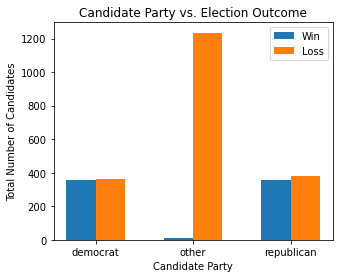

In [488]:
w = 0.3
fig, ax = plt.subplots(1,1,figsize=[5,4])
x = np.arange(len(data['party'].unique()))
ax.bar(x, data[(data['outcome'] == 1)].groupby(['party']).count()['outcome'], width=w, label='Win')
ax.bar(x+w, data[(data['outcome'] == 0)].groupby(['party']).count()['outcome'], width=w, label='Loss')
ax.set_xticks(x+w/2)
ax.set_xticklabels(data.groupby(['party']).count().index.values)
ax.set_xlabel('Candidate Party')
ax.set_ylabel('Total Number of Candidates')
ax.set_title('Candidate Party vs. Election Outcome')
ax.legend()
plt.show()

The proportion of Democrat and Republican candidates who win the election are very similar, but the proportion of "other" (third-party or independent) candidates who win is substantially smaller. As a result, we would expect whether a candidate is a third-party or independent candidate to be a strong predictor of election outcome.

### 2.2) Incumbency

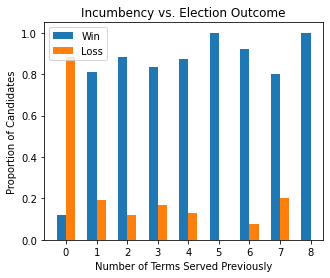

In [489]:
w = 0.3
fig, ax = plt.subplots(1,1,figsize=[5,4])
x = np.arange(len(data['incumbent'].unique()))
ax.bar(x, data[(data['outcome'] == 1)].groupby(['incumbent']).count()['outcome']/data.groupby(['incumbent']).count()['outcome'], width=w, label='Win')
ax.bar(x+w, data[(data['outcome'] == 0)].groupby(['incumbent']).count()['outcome']/data.groupby(['incumbent']).count()['outcome'], width=w, label='Loss')
ax.set_xticks(x+w/2)
ax.set_xticklabels(data.groupby(['incumbent']).count().index.values)
ax.set_xlabel('Number of Terms Served Previously')
ax.set_ylabel('Proportion of Candidates')
ax.set_title('Incumbency vs. Election Outcome')
ax.legend()
plt.show()

Candidates who have previously served 1 or more terms are much more likely to be elected than candidates who have not previously served as Senator.

### 2.3) Voter turnout

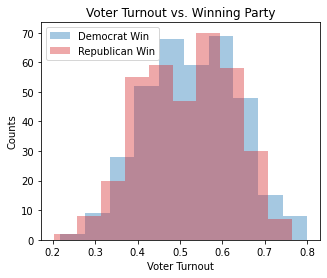

In [490]:
fig, ax = plt.subplots(1,1,figsize=[5,4])
ax.hist(data[((data['party'] == 'democrat') & (data['outcome'] == 1))]['turnout'], color='tab:blue',
        alpha=0.4, label='Democrat Win')
ax.hist(data[(data['party'] == 'republican') & (data['outcome'] == 1)]['turnout'],  color='tab:red',
        alpha=0.4, label='Republican Win')
ax.set_xlabel('Voter Turnout')
ax.set_ylabel('Counts')
ax.set_title('Voter Turnout vs. Winning Party')
ax.legend()
plt.show()

Voter turnout is slightly lower in states when Republicans win than when Democrats win.

### 2.4) Economic data

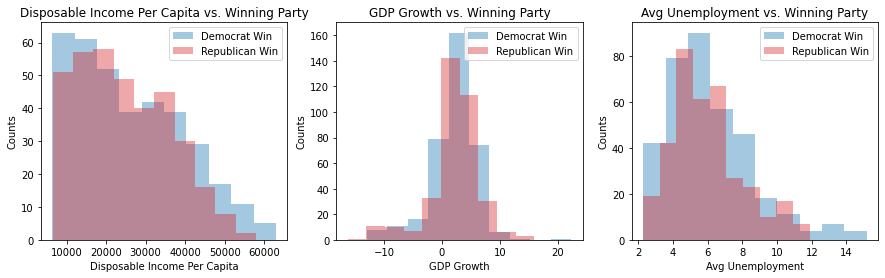

In [491]:
pred = ['Disposable Income Per Capita', 'GDP Growth','Avg Unemployment']
fig, axs = plt.subplots(1,3,figsize=[15,4])
for i, ax in enumerate(axs.ravel()):
    ax.hist(data[((data['party'] == 'democrat') & (data['outcome'] == 1))][pred[i]], color='tab:blue',
            alpha=0.4, label='Democrat Win')
    ax.hist(data[(data['party'] == 'republican') & (data['outcome'] == 1)][pred[i]],  color='tab:red',
            alpha=0.4, label='Republican Win')
    ax.set_xlabel(pred[i])
    ax.set_ylabel('Counts')
    ax.set_title(pred[i] + ' vs. Winning Party')
    ax.legend()
plt.show()

Disposable income per capita and average unemployment are both usually higher in states when Democrats win the election. The distribution of GDP growth is similar between Democrat wins and Republican wins, so we will not use GDP growth as a predictor in our model.

### 2.5) Demographic data

##### 2.5.1) Population size

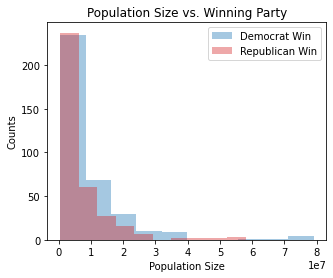

In [492]:
fig, ax = plt.subplots(1,1,figsize=[5,4])
ax.hist(data[((data['party'] == 'democrat') & (data['outcome'] == 1))]['Population'], color='tab:blue',
        alpha=0.4, label='Democrat Win')
ax.hist(data[(data['party'] == 'republican') & (data['outcome'] == 1)]['Population'],  color='tab:red',
        alpha=0.4, label='Republican Win')
ax.set_xlabel('Population Size')
ax.set_ylabel('Counts')
ax.set_title('Population Size vs. Winning Party')
ax.legend()
plt.show()

Democrats tend to win in states with larger populations.

##### 2.5.2) Sex

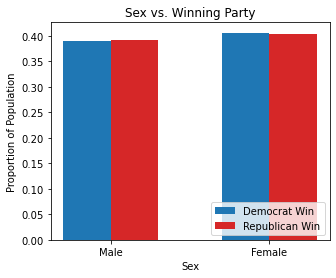

In [493]:
w = 0.3
fig, ax = plt.subplots(1,1,figsize=[5,4])
pred = ["Male","Female"]
x = np.arange(len(pred))
ax.bar(x, data[((data['party'] == 'democrat') & (data['outcome'] == 1))][pred].mean(), width=w, 
       color='tab:blue', label='Democrat Win')
ax.bar(x+w, data[((data['party'] == 'republican') & (data['outcome'] == 1))][pred].mean(), width=w, 
       color='tab:red', label='Republican Win')
ax.set_xticks(x+w/2)
ax.set_xticklabels(pred)
ax.set_xlabel('Sex')
ax.set_ylabel('Proportion of Population')
ax.set_title('Sex vs. Winning Party')
ax.legend(loc='lower right')
plt.show()

The proportion of males in the state's population is slightly lower and the proportion of females is slightly higher when Democrats win.

##### 2.5.3) Age

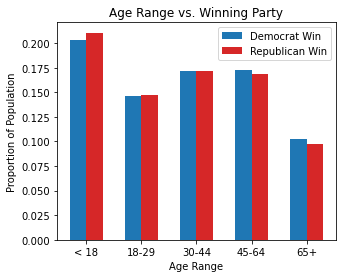

In [495]:
w = 0.3
fig, ax = plt.subplots(1,1,figsize=[5,4])
pred = ['Under 18 years', '18 to 29 years', '30 to 44 years', '45 to 64 years','65 years and over']
x = np.arange(len(pred))
ax.bar(x, data[((data['party'] == 'democrat') & (data['outcome'] == 1))][pred].mean(), width=w, 
       color='tab:blue', label='Democrat Win')
ax.bar(x+w, data[((data['party'] == 'republican') & (data['outcome'] == 1))][pred].mean(), width=w, 
       color='tab:red', label='Republican Win')
ax.set_xticks(x+w/2)
ax.set_xticklabels(['< 18', '18-29', '30-44', '45-64', '65+'])
ax.set_xlabel('Age Range')
ax.set_ylabel('Proportion of Population')
ax.set_title('Age Range vs. Winning Party')
ax.legend()
plt.show()

The proportion of the population that is under 18 years is lower, while the proportion of the population that is over 45 years old is higher in states when Democrats win the election. As a result, we will use those two age ranges as predictors in our model.

##### 2.5.4) Race

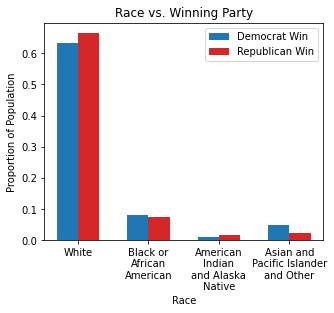

In [499]:
w = 0.3
fig, ax = plt.subplots(1,1,figsize=[5,4])
pred = ['White', 'Black or African American', 'American Indian and Alaska Native',
        'Asian and Pacific Islander and Other']
x = np.arange(len(pred))
ax.bar(x, data[((data['party'] == 'democrat') & (data['outcome'] == 1))][pred].mean(), width=w, 
       color='tab:blue', label='Democrat Win')
ax.bar(x+w, data[((data['party'] == 'republican') & (data['outcome'] == 1))][pred].mean(), width=w, 
       color='tab:red', label='Republican Win')
ax.set_xticks(x+w/2)
ax.set_xticklabels(['White', 'Black or\nAfrican\nAmerican', 'American\nIndian\nand Alaska\nNative',
        'Asian and\nPacific Islander\nand Other'])
ax.set_xlabel('Race')
ax.set_ylabel('Proportion of Population')
ax.set_title('Race vs. Winning Party')
ax.legend()
plt.show()

The proportion of the population who identify as White, American Indian, or Alaska Native, is higher in states when Republicans win, while the proportion of the population who identify as Black, Asian, Pacific Islander, or any other race is higher in states when Democrats win.

##### 2.5.5) Education

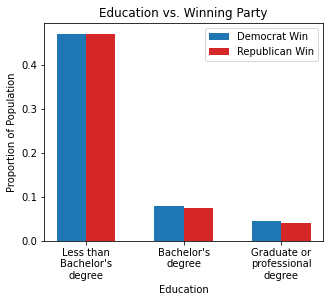

In [501]:
w = 0.3
fig, ax = plt.subplots(1,1,figsize=[5,4])
pred = ["Less than Bachelor's degree","Bachelor's degree", 'Graduate or professional degree']
x = np.arange(len(pred))
ax.bar(x, data[((data['party'] == 'democrat') & (data['outcome'] == 1))][pred].mean(), width=w, 
       color='tab:blue', label='Democrat Win')
ax.bar(x+w, data[((data['party'] == 'republican') & (data['outcome'] == 1))][pred].mean(), width=w, 
       color='tab:red', label='Republican Win')
ax.set_xticks(x+w/2)
ax.set_xticklabels(["Less than\nBachelor's\ndegree","Bachelor's\ndegree", 'Graduate or\nprofessional\ndegree'])
ax.set_xlabel('Education')
ax.set_ylabel('Proportion of Population')
ax.set_title('Education vs. Winning Party')
ax.legend()
plt.show()

The proportion of the population with at least a Bachelor's degree is higher in states when Democrats win, while the proportion of the population with less than a Bachelor's degree is higher in states when Republicans win.

**CONCLUSION:** From our EDA, we will use the following features in our model:
political party, incumbency, voter turnout, disposable income per capita, average unemployment, the following population metrics: size, age under 18, age over 45, White, Black or African American, American Indian and Alaska Native, Asian and Pacific Islander and Other, and at least a Bachelor's degree.



# 3) Build model

### 3.1) Create train, validation, and test sets

In [450]:
# Subset relevant features identified in EDA
data_all = pd.read_csv('data/data.csv')
pred = [
    'year','state','party','outcome','incumbent','turnout','Disposable Income Per Capita','Avg Unemployment',
    'Population','Under 18 years','White','Black or African American','American Indian and Alaska Native', 
    'Asian and Pacific Islander and Other'
]
data = data_all[pred].copy()
data['45 years and over'] = data_all['45 to 64 years'] + data_all['65 years and over']
data["Bachelor's degree or higher"] = data_all["Bachelor's degree"] + data_all['Graduate or professional degree']

# one-hot-encode categorical features (state and party)
cat = pd.get_dummies(data[['state','party']], prefix=['state','party'], drop_first=True)
data = pd.concat([data,cat],axis=1)

# separate test data (2020 election)
train = data[(data['year'] != 2020)]
test = data[(data['year'] == 2020)]

# separate outcome
X_train_raw = train.drop(columns=['outcome','state','party'])
y_train = train['outcome']
X_test_raw = test.drop(columns=['outcome','state','party'])
y_test = test['outcome']

# scale numerical variables
X_train_scale = X_train_raw.copy()
X_test = X_test_raw.copy()
num_vars = [v for v in X_train_raw.columns if len(X_train_raw[v].unique()) > 2]
scaler = StandardScaler().fit(X_train_raw[num_vars])
X_train_scale[num_vars] = scaler.transform(X_train_raw[num_vars])
X_test[num_vars] = scaler.transform(X_test_raw[num_vars])

# split training data into train + validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_scale, y_train, test_size=0.2, random_state=109)
df_names = ['X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test']
for i,df in enumerate((X_train, X_val, X_test, y_train, y_val, y_test)):
    df.reset_index(drop=True, inplace=True)
    print(f"Shape of {df_names[i]}: {df.shape}")

# generate quadratic and interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False).fit(X_train)
X_train_poly = poly.transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

Shape of X_train: (2059, 64)
Shape of X_val: (515, 64)
Shape of X_test: (130, 64)
Shape of y_train: (2059,)
Shape of y_val: (515,)
Shape of y_test: (130,)


### 3.2) Functions to calculate adjusted validation scores, and print accuracies

In [309]:
def adj_val(m):
    y_prob = m.predict_proba(X_val)[:,1]
    y_pred = np.zeros(len(y_prob))
    for i in range(13,62): # for each state
        idx = X_val[(X_val.iloc[:,i] == 1)].index.to_numpy()
        if len(idx) > 0:
            max_i = y_prob[idx].argmax()
            y_pred[idx[max_i]] = 1
    idx = X_val[X_val.iloc[:,13:62].eq(0).all(axis=1)].index.to_numpy() # dropped one state in one-hot-encoding
    max_i = y_prob[idx].argmax()
    y_pred[idx[max_i]] = 1
    return accuracy_score(y_val, y_pred)

def adj_val_poly(m):
    y_prob = m.predict_proba(X_val_poly)[:,1]
    y_pred = np.zeros(len(y_prob))
    for i in range(13,62): # for each state
        idx = np.where(X_val_poly[:,i] == 1)[0]
        if len(idx) > 0:
            max_i = y_prob[idx].argmax()
            y_pred[idx[max_i]] = 1
    idx = np.where(~X_val_poly[:,13:62].any(axis=1))[0] # dropped one state in one-hot-encoding
    max_i = y_prob[idx].argmax()
    y_pred[idx[max_i]] = 1
    return accuracy_score(y_val, y_pred)

def print_scores(m):
    print('Classification accuracy (train):', round(m.score(X_train, y_train),4))
    print('Classification accuracy (validation):', round(m.score(X_val, y_val),4))
    print('Classification accuracy (adjusted validation):', round(adj_val(m),4))

def print_scores_poly(m):
    print('Classification accuracy (train):', round(m.score(X_train_poly, y_train),4))
    print('Classification accuracy (validation):', round(m.score(X_val_poly, y_val),4))
    print('Classification accuracy (adjusted validation):', round(adj_val_poly(m),4))

### 3.3) Baseline model

In [451]:
baseline = LogisticRegression(penalty='none',max_iter=5000).fit(X_train,y_train)

# print coefficient estimates and classification accuracies
print("Logistic regression coefficients:")
for p, c in dict(zip(X_train.columns,baseline.coef_[0])).items():
    if p in num_vars or p == "party_other":
        print(f"\t{p}: {c:.4f}")
print()
print_scores(baseline)

Logistic regression coefficients:
	year: 0.6192
	incumbent: 1.3172
	turnout: -0.0788
	Disposable Income Per Capita: -0.3277
	Avg Unemployment: 0.0363
	Population: -0.0666
	Under 18 years: -0.1334
	White: 0.5530
	Black or African American: 0.2175
	American Indian and Alaska Native: -0.0019
	Asian and Pacific Islander and Other: 0.0346
	45 years and over: 0.0716
	Bachelor's degree or higher: -0.4865
	party_other: -4.0935

Classification accuracy (train): 0.863
Classification accuracy (validation): 0.8524
Classification accuracy (adjusted validation): 0.8019


### 3.4) Logistic Regression

In [321]:
logit_models = []

print("Logistic Regression + LASSO regularization + 3-fold CV")
logit = LogisticRegressionCV(cv=3, penalty='l1', solver='liblinear', max_iter=5000).fit(X_train,y_train)
logit_models.append(logit)
print_scores(logit)
nonzero_coefs = [c for c in logit.coef_[0] if c != 0]
print(f"Number of non-zero coefficients: {len(nonzero_coefs)}")
for p, c in dict(zip(X_train.columns,logit.coef_[0])).items():
    if c != 0:
        print(f"\t{p}: {c:.4f}")
print()

print("Logistic Regression + Ridge regularization + 3-fold CV")
logit = LogisticRegressionCV(cv=3, penalty='l2', solver='lbfgs', max_iter=5000).fit(X_train,y_train)
logit_models.append(logit)
print_scores(logit)

Logistic Regression + LASSO regularization + 3-fold CV
Classification accuracy (train): 0.8723
Classification accuracy (validation): 0.8796
Classification accuracy (adjusted validation): 0.8097
Number of non-zero coefficients: 2
	incumbent: 0.6236
	party_other: -1.0164

Logistic Regression + Ridge regularization + 3-fold CV
Classification accuracy (train): 0.8679
Classification accuracy (validation): 0.8699
Classification accuracy (adjusted validation): 0.8019


In [322]:
print("Logistic Regression + polynomial features")
logit = LogisticRegression(penalty='none',max_iter=10000).fit(X_train_poly,y_train)
logit_models.append(logit)
print_scores_poly(logit)
print()

print("Logistic Regression + polynomial features + LASSO regularization")
logit = LogisticRegression(penalty='l1',solver='saga',max_iter=5000).fit(X_train_poly,y_train)
logit_models.append(logit)
print_scores_poly(logit)
nonzero_coefs = [c for c in logit.coef_[0] if c != 0]
print(f"Number of non-zero coefficients: {len(nonzero_coefs)} out of {X_train_poly.shape[1]}")
print()

print("Logistic Regression + polynomial features + Ridge regularization")
logit = LogisticRegression(penalty='l2',solver='lbfgs',max_iter=5000).fit(X_train_poly,y_train)
logit_models.append(logit)
print_scores_poly(logit)

Logistic Regression + polynomial features


/Users/janetli/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Classification accuracy (train): 0.9655
Classification accuracy (validation): 0.7534
Classification accuracy (adjusted validation): 0.767

Logistic Regression + polynomial features + LASSO regularization
Classification accuracy (train): 0.9038
Classification accuracy (validation): 0.8544
Classification accuracy (adjusted validation): 0.8058
Number of non-zero coefficients: 241 out of 2144

Logistic Regression + polynomial features + Ridge regularization
Classification accuracy (train): 0.9189
Classification accuracy (validation): 0.8466
Classification accuracy (adjusted validation): 0.7864


### 3.5) Support Vector Machines

In [326]:
svc_models = []

print("SVC with linear kernel")
model = SVC(kernel='linear',probability=True).fit(X_train,y_train)
svc_models.append(model)
print_scores(model)
print()

print("SVC with polynomial (degree 3) kernel")
model = SVC(kernel='poly',probability=True).fit(X_train,y_train)
svc_models.append(model)
print_scores(model)

SVC with linear kernel
Classification accuracy (train): 0.8718
Classification accuracy (validation): 0.8796
Classification accuracy (adjusted validation): 0.8019

SVC with polynomial (degree 3) kernel
Classification accuracy (train): 0.8601
Classification accuracy (validation): 0.866
Classification accuracy (adjusted validation): 0.8058


In [327]:
print("SVC with rbf (radial basis function) kernel")
C_range = np.logspace(-2, 4, 7)
gamma_range = np.logspace(-3, 3, 7)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=3)
grid.fit(X_train, y_train)

print(f"The best parameters are {grid.best_params_} with a score of {grid.best_score_:.2f}")

SVC with rbf (radial basis function) kernel
The best parameters are {'C': 10.0, 'gamma': 0.01} with a score of 0.87


In [331]:
print("SVC with rbf (radial basis function) kernel, C = 10, gamma = 0.01")
model = SVC(kernel='rbf', C=10, gamma=0.01, probability=True).fit(X_train,y_train)
svc_models.append(model)
print_scores(model)

SVC with rbf (radial basis function) kernel, C = 10, gamma = 0.01
Classification accuracy (train): 0.8723
Classification accuracy (validation): 0.8796
Classification accuracy (adjusted validation): 0.8097


In [332]:
print("SVC with linear kernel + polynomial features")
model = SVC(kernel='linear', probability=True).fit(X_train_poly,y_train)
svc_models.append(model)
print_scores_poly(model)
print()

print("SVC with polynomial (degree 3) kernel + polynomial features")
model = SVC(kernel='poly', probability=True).fit(X_train_poly,y_train)
svc_models.append(model)
print_scores_poly(model)
print()

print("SVC with rbf kernel, C = 10, gamma = 0.01 + polynomial features")
model = SVC(kernel='rbf', C=10, gamma=0.01, probability=True).fit(X_train_poly,y_train)
svc_models.append(model)
print_scores_poly(model)

SVC with linear kernel + polynomial features
Classification accuracy (train): 0.931
Classification accuracy (validation): 0.8466
Classification accuracy (adjusted validation): 0.7825

SVC with polynomial (degree 3) kernel + polynomial features
Classification accuracy (train): 0.8048
Classification accuracy (validation): 0.8
Classification accuracy (adjusted validation): 0.7981

SVC with rbf kernel, C = 10, gamma = 0.01 + polynomial features
Classification accuracy (train): 0.9704
Classification accuracy (validation): 0.8369
Classification accuracy (adjusted validation): 0.7825


### 3.6) k-NN

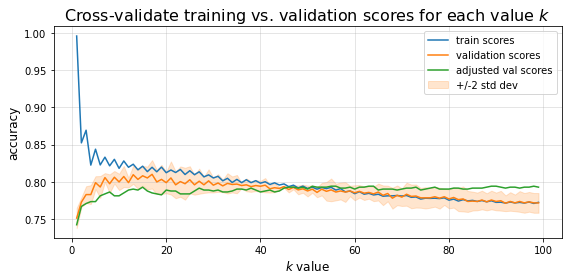

In [353]:
ks = np.arange(1,100)

train_score = np.zeros(len(ks))
validation_score = np.zeros(len(ks))
validation_var = np.zeros(len(ks))
adj_val_score = np.zeros(len(ks))

for i, k in enumerate(ks):
    cv_results = cross_validate(
        estimator=KNeighborsClassifier(n_neighbors=k),
        X=X_train,
        y=y_train,
        cv=3,
        return_train_score=True,
        return_estimator=True
    )
    train_score[i] = np.mean(cv_results["train_score"])
    validation_score[i] = np.mean(cv_results["test_score"])
    validation_var[i] = np.std(cv_results["test_score"])
    adj_val_score[i] = np.mean([adj_val(m) for m in cv_results["estimator"]])
    
fig, ax = plt.subplots(figsize=(8,4))
plt.title(
    "Cross-validate training vs. validation scores for each value $k$",
    fontsize=16,
)
plt.plot(ks, train_score, label="train scores")
plt.plot(ks, validation_score, label="validation scores")
plt.fill_between(
    ks, validation_score+2*validation_var, validation_score-2*validation_var,
    color='tab:orange', alpha=0.2, label="+/-2 std dev")
plt.plot(ks, adj_val_score, label="adjusted val scores")
plt.grid(':', alpha=0.4)
plt.xlabel("$k$ value", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [354]:
best_k = 35
print(f"Best k: {best_k}")

knn = KNeighborsClassifier(n_neighbors=best_k).fit(X_train,y_train)
print_scores(knn)

Best k: 35
Classification accuracy (train): 0.8135
Classification accuracy (validation): 0.8136
Classification accuracy (adjusted validation): 0.7864


### 3.7) Trees

In [377]:
tree_models = []

##### 3.7.1) Single Decision Trees

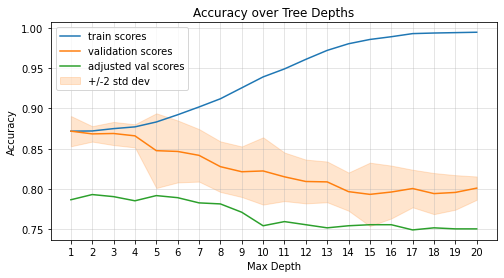

In [378]:
# decision tree with optimal depth from 3-fold CV

depths = list(range(1, 21))

train_score = np.zeros(len(depths))
validation_score = np.zeros(len(depths))
validation_var = np.zeros(len(depths))
adj_val_score = np.zeros(len(depths))

for i,depth in enumerate(depths):
    cv_results = cross_validate(
        estimator=DecisionTreeClassifier(max_depth=depth),
        X=X_train,
        y=y_train,
        cv=3,
        return_train_score=True,
        return_estimator=True
    )
    train_score[i] = np.mean(cv_results["train_score"])
    validation_score[i] = np.mean(cv_results["test_score"])
    validation_var[i] = np.std(cv_results["test_score"])
    adj_val_score[i] = np.mean([adj_val(m) for m in cv_results["estimator"]])

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(depths, train_score, label="train scores")
plt.plot(depths, validation_score, label="validation scores")
plt.fill_between(
    depths, validation_score+2*validation_var, validation_score-2*validation_var,
    color='tab:orange', alpha=0.2, label="+/-2 std dev")
plt.plot(depths, adj_val_score, label="adjusted val scores")
plt.grid(':', alpha=0.4)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.title("Accuracy over Tree Depths")
plt.xticks(depths)
plt.show()

In [379]:
best_depth = depths[adj_val_score.argmax()]
print(f"Best tree depth: {best_depth}")

tree = DecisionTreeClassifier(max_depth=best_depth).fit(X_train, y_train)
tree_models.append(tree)
print_scores(tree)

Best tree depth: 2
Classification accuracy (train): 0.8718
Classification accuracy (validation): 0.8796
Classification accuracy (adjusted validation): 0.7903


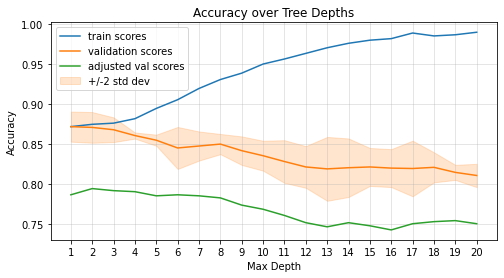

In [380]:
# decision tree with optimal depth from 3-fold CV + polynomial features

depths = list(range(1, 21))

train_score = np.zeros(len(depths))
validation_score = np.zeros(len(depths))
validation_var = np.zeros(len(depths))
adj_val_score = np.zeros(len(depths))
for i,depth in enumerate(depths):
    cv_results = cross_validate(
        estimator=DecisionTreeClassifier(max_depth=depth),
        X=X_train_poly,
        y=y_train,
        cv=3,
        return_train_score=True,
        return_estimator=True
    )
    train_score[i] = np.mean(cv_results["train_score"])
    validation_score[i] = np.mean(cv_results["test_score"])
    validation_var[i] = np.std(cv_results["test_score"])
    adj_val_score[i] = np.mean([adj_val_poly(m) for m in cv_results["estimator"]])

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(depths, train_score, label="train scores")
plt.plot(depths, validation_score, label="validation scores")
plt.fill_between(
    depths, validation_score+2*validation_var, validation_score-2*validation_var,
    color='tab:orange', alpha=0.2, label="+/-2 std dev")
plt.plot(depths, adj_val_score, label="adjusted val scores")
plt.grid(':', alpha=0.4)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.title("Accuracy over Tree Depths")
plt.xticks(depths)
plt.show()

In [381]:
best_depth = depths[adj_val_score.argmax()]
print(f"Best tree depth: {best_depth}")

tree = DecisionTreeClassifier(max_depth=best_depth).fit(X_train_poly, y_train)
tree_models.append(tree)
print_scores_poly(tree)

Best tree depth: 2
Classification accuracy (train): 0.8742
Classification accuracy (validation): 0.8796
Classification accuracy (adjusted validation): 0.7942


##### 3.7.2) Random Forest

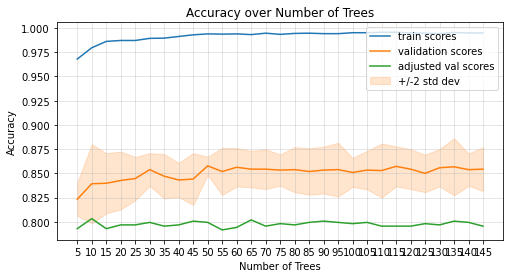

In [382]:
tree_depth = 16
ns = np.arange(5, 150, 5)

train_score = np.zeros(len(ns))
validation_score = np.zeros(len(ns))
validation_var = np.zeros(len(ns))
adj_val_score = np.zeros(len(ns))

for i,n in enumerate(ns):
    cv_results = cross_validate(
        estimator=RandomForestClassifier(n_estimators=n, max_features='sqrt', max_depth=tree_depth),
        X=X_train,
        y=y_train,
        cv=3,
        return_train_score=True,
        return_estimator=True
    )
    train_score[i] = np.mean(cv_results["train_score"])
    validation_score[i] = np.mean(cv_results["test_score"])
    validation_var[i] = np.std(cv_results["test_score"])
    adj_val_score[i] = np.mean([adj_val(m) for m in cv_results["estimator"]])
    
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(ns, train_score, label="train scores")
plt.plot(ns, validation_score, label="validation scores")
plt.fill_between(
    ns, validation_score+2*validation_var, validation_score-2*validation_var,
    color='tab:orange', alpha=0.2, label="+/-2 std dev")
plt.plot(ns, adj_val_score, label="adjusted val scores")
plt.grid(':', alpha=0.4)
plt.legend(loc='upper right')
plt.ylabel("Accuracy")
plt.xlabel("Number of Trees")
plt.title("Accuracy over Number of Trees")
plt.xticks(ns)
plt.show()

In [383]:
n_trees = ns[np.argmax(adj_val_score)]
print(f"Best number of trees: {n_trees}")

rf = RandomForestClassifier(n_estimators=n_trees, max_features='sqrt', max_depth=tree_depth).fit(X_train, y_train)
tree_models.append(rf)
print_scores(rf)

Best number of trees: 10
Classification accuracy (train): 0.9733
Classification accuracy (validation): 0.8427
Classification accuracy (adjusted validation): 0.7981


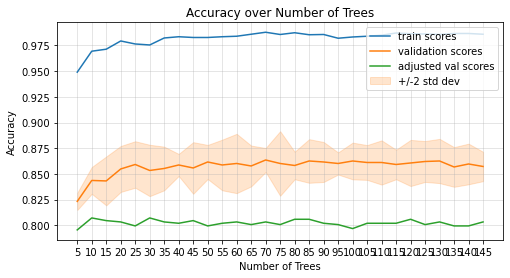

In [384]:
tree_depth = 16
ns = np.arange(5, 150, 5)

train_score = np.zeros(len(ns))
validation_score = np.zeros(len(ns))
validation_var = np.zeros(len(ns))
adj_val_score = np.zeros(len(ns))

for i,n in enumerate(ns):
    cv_results = cross_validate(
        estimator=RandomForestClassifier(n_estimators=n, max_features='sqrt', max_depth=tree_depth),
        X=X_train_poly,
        y=y_train,
        cv=3,
        return_train_score=True,
        return_estimator=True
    )
    train_score[i] = np.mean(cv_results["train_score"])
    validation_score[i] = np.mean(cv_results["test_score"])
    validation_var[i] = np.std(cv_results["test_score"])
    adj_val_score[i] = np.mean([adj_val_poly(m) for m in cv_results["estimator"]])
    
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(ns, train_score, label="train scores")
plt.plot(ns, validation_score, label="validation scores")
plt.fill_between(
    ns, validation_score+2*validation_var, validation_score-2*validation_var,
    color='tab:orange', alpha=0.2, label="+/-2 std dev")
plt.plot(ns, adj_val_score, label="adjusted val scores")
plt.grid(':', alpha=0.4)
plt.legend(loc='upper right')
plt.ylabel("Accuracy")
plt.xlabel("Number of Trees")
plt.title("Accuracy over Number of Trees")
plt.xticks(ns)
plt.show()

In [385]:
n_trees_poly = 30
print(f"Best number of trees: {n_trees_poly}")

rf_poly = RandomForestClassifier(n_estimators=n_trees_poly, max_features='sqrt', max_depth=tree_depth).fit(
    X_train_poly, y_train)
tree_models.append(rf_poly) 
print_scores_poly(rf_poly)

Best number of trees: 30
Classification accuracy (train): 0.9553
Classification accuracy (validation): 0.866
Classification accuracy (adjusted validation): 0.8058


##### 3.7.3) AdaBoost

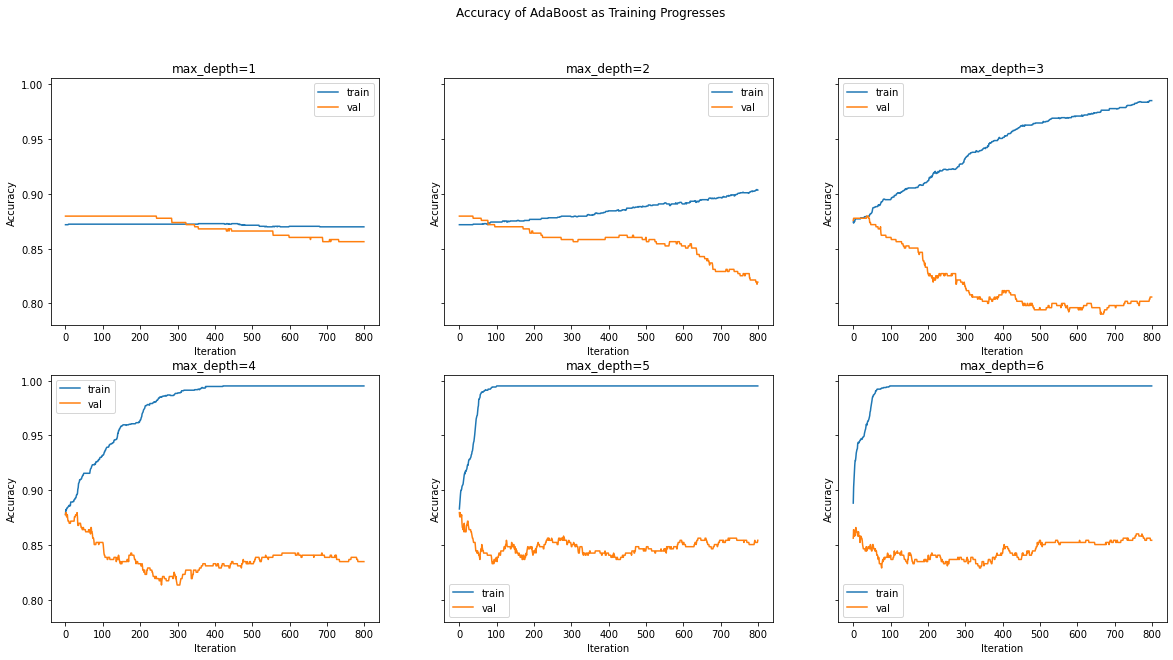

In [387]:
# AdaBoost
clfs = {}
train_scores = {}
val_scores = {}
for depth in range(1,7):
    fitted_ada = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=depth),
        n_estimators=800,
        learning_rate=.05).fit(X_train, y_train)
    train_scores[depth] = list(fitted_ada.staged_score(X_train, y_train))
    val_scores[depth] = list(fitted_ada.staged_score(X_val, y_val))
    clfs[depth] = fitted_ada
    
fig, axs = plt.subplots(2, 3, figsize=(20,10), sharey=True)
for ax, depth in zip(axs.ravel(), (1,2,3,4,5,6)):
    ax.plot(train_scores[depth], label='train')
    ax.plot(val_scores[depth], label='val')
    ax.set(xlabel='Iteration', ylabel='Accuracy', title=f"max_depth={depth}")
    ax.legend()
plt.suptitle("Accuracy of AdaBoost as Training Progresses")
plt.show()

In [401]:
tree_depth=3
n=50

ada = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=tree_depth),
        n_estimators=n,
        learning_rate=.05).fit(X_train, y_train)
tree_models.append(ada)
print_scores(ada)

Classification accuracy (train): 0.8825
Classification accuracy (validation): 0.8718
Classification accuracy (adjusted validation): 0.8097


# 4) Model Comparisons

### 4.1) Best models of each group

In [407]:
scores = {}
models = [('Baseline',baseline, False), ('Logistic Regression (LASSO)', logit_models[0], False), 
          ('SVC with rbf kernel', svc_models[2], False), ('k-NN', knn, False), ('AdaBoost', ada, False)]
for name, m, poly in models:
    scores[name] = []
    if poly:
        scores[name].append(m.score(X_train_poly, y_train))
        scores[name].append(m.score(X_val_poly, y_val))
        scores[name].append(adj_val_poly(m))
    else:
        scores[name].append(m.score(X_train, y_train))
        scores[name].append(m.score(X_val, y_val))
        scores[name].append(adj_val(m))

scores_df = pd.DataFrame.from_dict(scores, orient='index', 
                                   columns=['train', 'validation', 'adj validation']).apply(lambda x: round(x,4))
display(scores_df)

,train,validation,adj validation
Baseline,0.8630,0.8524,0.8019
Logistic Regression (LASSO),0.8723,0.8796,0.8097
SVC with rbf kernel,0.8723,0.8796,0.8097
k-NN,0.8135,0.8136,0.7864
AdaBoost,0.8825,0.8718,0.8097


The best models are Logistic Regression with LASSO regularization and SVM classifier with rbf kernel, as they had the highest adjusted validation score and validation score.

### 4.2) Visualize Predictions

In [485]:
best_models = (logit_models[0],svc_models[2])

In [452]:
# calculate predicted y values, return adjusted accuracy on test set and indices of winning candidates
def get_winners(m):
    y_prob = m.predict_proba(X_test)[:,1]
    y_pred = np.zeros(len(y_prob))
    win_idx = []
    for i in range(13,62): # for each state
        idx = X_test[(X_test.iloc[:,i] == 1)].index.to_numpy()
        if len(idx) > 0:
            max_i = y_prob[idx].argmax()
            y_pred[idx[max_i]] = 1
            win_idx.append(idx[max_i])
    idx = X_test[X_test.iloc[:,13:62].eq(0).all(axis=1)].index.to_numpy() # dropped one state in one-hot-encoding
    max_i = y_prob[idx].argmax()
    y_pred[idx[max_i]] = 1
    win_idx.append(idx[max_i])
    return (accuracy_score(y_test,y_pred), win_idx)

def print_test_scores(m):
    print('Classification accuracy (test):', round(m.score(X_test, y_test),4))
    print('Classification accuracy (adjusted test):', round(get_winners(m)[0],4))

In [453]:
# predict Georgia

georgia = pd.read_csv('data/georgia.csv')
georgia = georgia.drop(columns=['outcome'])
georgia_train = georgia.drop(columns=['state','party','candidate']).copy()
georgia_train[num_vars] = scaler.transform(georgia[num_vars])

for m in best_models:
    ga_prob = m.predict_proba(georgia_train)[:,1]
    idx = np.argsort(ga_prob)[::-1][:2]
    ga = georgia['party'][idx].values
    print(f"Georgia results: {ga}")

Georgia results: ['republican' 'democrat']
Georgia results: ['republican' 'democrat']


In [479]:
def get_state_results(model):
    state_results={}
    dem_seats, rep_seats, other_seats = 0, 0, 0
    for i in get_winners(model)[1]:
        state = test.iloc[i,:]['state']
        if test.iloc[i,:]['party'] == 'democrat':
            state_results[state] = 0
            dem_seats += 1
        elif test.iloc[i,:]['party'] == 'republican':
            state_results[state] = 1
            rep_seats += 1
        else:
            state_results[state] = 2
            other_seats += 1
    # add georgia results (1 rep win, 1 dem win)
    state_results["Georgia"] = 3
    dem_seats += 1
    rep_seats += 1
    
    print(f"Democrats gained {dem_seats}; Republicans gained {rep_seats}; other parties gained {other_seats}.")
    return state_results

def election_map(state_results, title):    
    # Set state style
    def state_style(state, function=False):
        if state in state_results.keys():
            result = state_results[state]
            if result == 0:
                color = '#4f7bff' # blue, democrat
            elif result == 1:
                color = '#ff5b4f' # red, republican
            elif result == 2:
                color = '#009900' # green, other
            elif result == 3:
                color = '#800080' # purple, split 1 dem, 1 rep
        else:
            color = '#a9a9a9' # gray, no election in 2020
        if function == False:
            state_style = {'opacity': 1, 'color': color} 
        else:
            state_style = {'fillOpacity': 1, 'weight': 1, 'fillColor': color, 'color': '#000000'}    
        return state_style

    def style_function(feature):
        state = feature['properties']['state_name']
        style = state_style(state, function=True)
        return style
    
    us_shape = gpd.read_file('data/state_shapes/states.shp')
    us_shape = us_shape[['state_name','geometry']]

    # create map
    m = folium.Map(location=[37, -102], zoom_start=4)
    choropleth = folium.GeoJson(data=us_shape.to_json(), style_function=style_function)
    m.add_child(choropleth)

    # add legend
    colormap = cm.StepColormap(colors=['blue', 'purple', 'red', 'green'], index=[0,0.25,0.5,0.75],
                               caption=title)
    m.add_child(colormap)
    return m

In [482]:
for m in best_models:
    print(m)
    print_test_scores(m)
    display(election_map(get_state_results(m), "2020 Senate Election Predictions by State"))
    print()

LogisticRegressionCV(cv=3, max_iter=5000, penalty='l1', solver='liblinear')
Classification accuracy (test): 0.9231
Classification accuracy (adjusted test): 0.9538
Democrats gained 13; Republicans gained 22; other parties gained 0.



SVC(C=10, gamma=0.01, probability=True)
Classification accuracy (test): 0.9231
Classification accuracy (adjusted test): 0.9077
Democrats gained 16; Republicans gained 19; other parties gained 0.


In [484]:
state_results = {}
for state in test['state'].unique():
    test_state = test[(test['state'] == state)]
    party = test_state[(test_state['outcome'] == 1)]['party'].values[0]
    if party == 'democrat':
        state_results[state] = 0
    elif party == 'republican':
        state_results[state] = 1
    else:
        print(f"Error: winner in {state} is from {party} party")
election_map(state_results, "2020 Senate Election Results")